# Imports

In [511]:
import pandas
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

In [512]:
data_file = 'data/continuous_dataset.csv'
df = pd.read_csv(data_file)

data_file = 'data/weekly_pre_dispatch_forecast.csv'
df_forecast_pre_dispatch = pd.read_csv(data_file)

In [513]:
# This dataset contains the feature variables and dependent variable datetime.
df

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
48044,2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
48045,2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1
48046,2020-06-26 23:00:00,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1


In [514]:
# Load forecast in the pre dispatch reports is the prediction made by the grid operator.
# This is not a feature for our model but could be compared with our predictions as an exploratory activity.
df_forecast_pre_dispatch

,datetime,load_forecast
0,1/2/2016 0:00,1056.9
1,1/2/2016 1:00,1057.1
2,1/2/2016 2:00,996.5
3,1/2/2016 3:00,955.8
4,1/2/2016 4:00,918.0
...,...,...
40147,7/31/2020 19:00,1181.4
40148,7/31/2020 20:00,1196.8
40149,7/31/2020 21:00,1163.3
40150,7/31/2020 22:00,1136.0


In [515]:
df.describe()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
count,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000
mean,1182.868647,27.399111,0.018313,0.079979,13.391049,26.921023,0.017844,0.106265,7.046675,24.719513,0.016867,0.144681,3.567589,0.704795,0.062937,0.727793
std,192.068896,1.675462,0.001607,0.065589,7.295502,3.018129,0.001889,0.086293,4.103711,2.414019,0.001584,0.087899,1.710522,3.147470,0.242852,0.445100
min,85.192500,22.953455,0.012054,0.000000,0.008979,19.765222,0.010247,0.000009,0.060394,19.933740,0.009655,0.000032,0.015497,0.000000,0.000000,0.000000
25%,1020.056900,26.160455,0.017236,0.026451,7.544958,24.769281,0.016584,0.036819,3.955051,22.954652,0.015800,0.075775,2.298887,0.000000,0.000000,0.000000
50%,1168.427700,27.118051,0.018590,0.065201,12.182103,26.167352,0.018351,0.085968,5.992762,24.001718,0.017167,0.130188,3.413994,0.000000,0.000000,1.000000
75%,1327.563950,28.558344,0.019521,0.117310,18.661282,28.712335,0.019242,0.157288,9.409871,26.243402,0.018067,0.200012,4.670628,0.000000,0.000000,1.000000
max,1754.882000,35.039575,0.022690,0.521240,39.229726,39.063440,0.022165,0.484985,24.483937,34.216211,0.021066,0.477783,10.288902,22.000000,1.000000,1.000000


In [516]:
# Checking if there are missing values. None found.
df.isna().sum()

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

In [517]:
# Making columns lower case for better readability.
df.columns = df.columns.str.lower()
df

,datetime,nat_demand,t2m_toc,qv2m_toc,tql_toc,w2m_toc,t2m_san,qv2m_san,tql_san,w2m_san,t2m_dav,qv2m_dav,tql_dav,w2m_dav,holiday_id,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
48044,2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
48045,2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1
48046,2020-06-26 23:00:00,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1


In [518]:
# Check the data types of the variables
df.dtypes

datetime       object
nat_demand    float64
t2m_toc       float64
qv2m_toc      float64
tql_toc       float64
w2m_toc       float64
t2m_san       float64
qv2m_san      float64
tql_san       float64
w2m_san       float64
t2m_dav       float64
qv2m_dav      float64
tql_dav       float64
w2m_dav       float64
holiday_id      int64
holiday         int64
school          int64
dtype: object

In [519]:
# Checking if variable `school` has non-boolean values
df.school.value_counts()

1    34969
0    13079
Name: school, dtype: int64

In [520]:
# Checking if variable `holiday` has non-boolean values
df.holiday.value_counts()

0    45024
1     3024
Name: holiday, dtype: int64

Checking if 0's in `holiday_id` matches the number of holidays based on `holiday`.

In [521]:
assert df.holiday_id.value_counts()[0] == df.holiday.value_counts()[0]

In [522]:
# datetime is a string. Splitting it to multiple columns will make plotting easier.
# Therefore, creating a new variable called `dt` of type pd.datetime by converting the values from `df.datetime`.
df['dt'] = pd.to_datetime(df.datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Checking if there are datetime conversion errors.
assert df.dt.isnull().sum() == 0

# delete datetime from the dataframe as dt supersedes it now.
del df['datetime']

In [523]:
df

,nat_demand,t2m_toc,qv2m_toc,tql_toc,w2m_toc,t2m_san,qv2m_san,tql_san,w2m_san,t2m_dav,qv2m_dav,tql_dav,w2m_dav,holiday_id,holiday,school,dt
0,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0,2015-01-03 01:00:00
1,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0,2015-01-03 02:00:00
2,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0,2015-01-03 03:00:00
3,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0,2015-01-03 04:00:00
4,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0,2015-01-03 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1,2020-06-26 20:00:00
48044,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1,2020-06-26 21:00:00
48045,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1,2020-06-26 22:00:00
48046,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1,2020-06-26 23:00:00


In [524]:
df['dt_year'] = df['dt'].dt.year
df['dt_month'] = df['dt'].dt.month
df['dt_day'] = df['dt'].dt.day
df['dt_hour'] = df['dt'].dt.hour

# No need to separate minute and second values as they are always 0. Verified and confirmed.
# df['dt_minute'] = df.datetime.dt.minute
# df['dt_second'] = df.datetime.dt.second


In [525]:
# Visually check all dt variables that they've been split correctly from a semantic viewpoint.
# Programmatic check was done above by checking for conversion errors.
df[df.columns[df.columns.str.match('^dt.*')]][::100]

,dt,dt_year,dt_month,dt_day,dt_hour
0,2015-01-03 01:00:00,2015,1,3,1
100,2015-01-07 05:00:00,2015,1,7,5
200,2015-01-11 09:00:00,2015,1,11,9
300,2015-01-15 13:00:00,2015,1,15,13
400,2015-01-19 17:00:00,2015,1,19,17
...,...,...,...,...,...
47600,2020-06-08 09:00:00,2020,6,8,9
47700,2020-06-12 13:00:00,2020,6,12,13
47800,2020-06-16 17:00:00,2020,6,16,17
47900,2020-06-20 21:00:00,2020,6,20,21


In [526]:
df.groupby(by=['dt_year', 'dt_month']).size()

dt_year  dt_month
2015     1           695
         2           672
         3           744
         4           720
         5           744
                    ... 
2020     2           696
         3           744
         4           720
         5           744
         6           625
Length: 66, dtype: int64

In [527]:
# df[['t2m_toc', 't2m_san', 't2m_dav', 'dt_year', 'dt_month']].groupby(by=['dt_year', 'dt_month'], group_keys=True).max().plot().bar()

In [528]:
# distribution of the target variable
# %matplotlib inline
# plt.figure(figsize=(10,10))
# sns.histplot(df.nat_demand)
# sns.histplot(y_pred, color='red', bins=50, alpha=0.5)

df.dtypes

nat_demand           float64
t2m_toc              float64
qv2m_toc             float64
tql_toc              float64
w2m_toc              float64
t2m_san              float64
qv2m_san             float64
tql_san              float64
w2m_san              float64
t2m_dav              float64
qv2m_dav             float64
tql_dav              float64
w2m_dav              float64
holiday_id             int64
holiday                int64
school                 int64
dt            datetime64[ns]
dt_year                int64
dt_month               int64
dt_day                 int64
dt_hour                int64
dtype: object

In [529]:
df.nat_demand

0         970.3450
1         912.1755
2         900.2688
3         889.9538
4         893.6865
           ...    
48043    1128.5592
48044    1112.7488
48045    1081.5680
48046    1041.6240
48047    1013.5683
Name: nat_demand, Length: 48048, dtype: float64

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

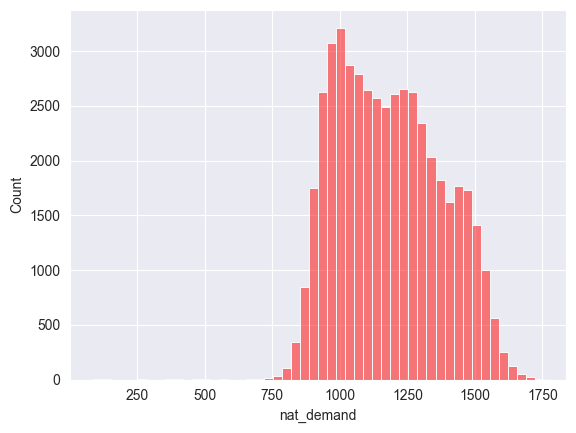

In [530]:
sns.histplot(df.nat_demand, color='red', bins=50, alpha=0.5)

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

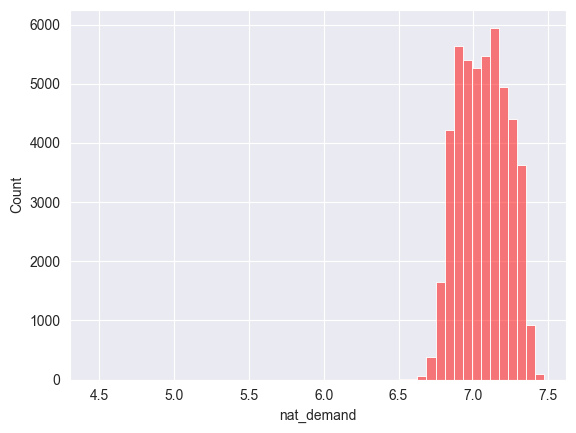

In [531]:
# See the distribution of the log1p version of the target variable
sns.histplot(np.log1p(df.nat_demand), color='red', bins=50, alpha=0.5)

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

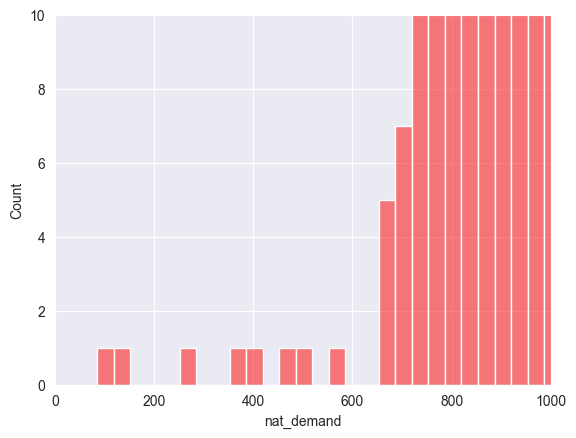

In [532]:
# Focusing on the long tail on the left. They seem to be outliers.
plt.xlim(0, 1000)
plt.ylim(0, 10)
sns.histplot(df.nat_demand, color='red', bins=50, alpha=0.5)

In [533]:
# Looks like there are 8 very low demands. This is only a 0.017% of the total records.
# Without these outliers the national demand values are 'normally' distributed.
# Therefore, no need to log1p() the values.
round(df.nat_demand[df.nat_demand < 600].size / len(df.nat_demand) * 100, 3)

0.017

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

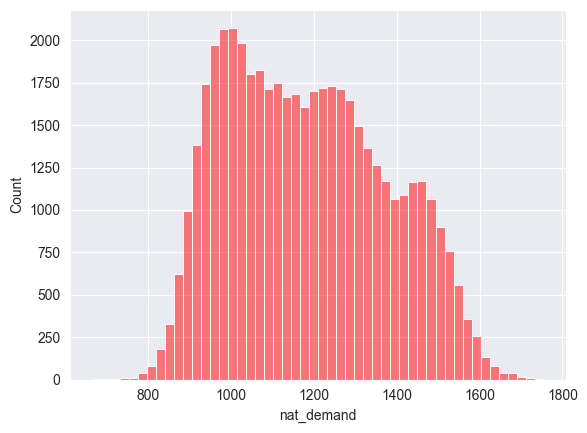

In [534]:
sns.histplot(df.nat_demand[df.nat_demand > 600], color='red', bins=50, alpha=0.5)

In [535]:
# Splitting the dataset to 80%, 20%, 20% for training, validation, and testing, respectively.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(f'train:val:test split is {(len(df_train), len(df_val), len(df_test))}')

# Also create a copy of the complete dataframe with order intact to plot actual vs forecast based on the final model.
df_full = df.copy()
print(f'complete dataset is {len(df_full)}')

train:val:test split is (28828, 9610, 9610)
complete dataset is 48048


In [536]:
# Resetting indices
df_full_train.reset_index(inplace=True)
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_full.reset_index(
    inplace=True)  # not necessary, but done so the for-loop below doesn't fail due to not having an index column.

In [537]:
y_full_train = df_full_train.nat_demand
y_train = df_train.nat_demand
y_val = df_val.nat_demand
y_test = df_test.nat_demand
y_full = df_full.nat_demand

# log1p
# y_train = np.log1p(df_train.nat_demand)
# y_val = np.log1p(df_val.nat_demand)
# y_test = np.log1p(df_test.nat_demand)

In [538]:
df_full

,index,nat_demand,t2m_toc,qv2m_toc,tql_toc,w2m_toc,t2m_san,qv2m_san,tql_san,w2m_san,...,tql_dav,w2m_dav,holiday_id,holiday,school,dt,dt_year,dt_month,dt_day,dt_hour
0,0,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,...,0.096100,5.364148,0,0,0,2015-01-03 01:00:00,2015,1,3,1
1,1,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,...,0.087646,5.572471,0,0,0,2015-01-03 02:00:00,2015,1,3,2
2,2,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,...,0.078735,5.871184,0,0,0,2015-01-03 03:00:00,2015,1,3,3
3,3,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,...,0.068390,5.883621,0,0,0,2015-01-03 04:00:00,2015,1,3,4
4,4,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,...,0.064362,5.611724,0,0,0,2015-01-03 05:00:00,2015,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,48043,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,...,0.150879,2.444658,0,0,1,2020-06-26 20:00:00,2020,6,26,20
48044,48044,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,...,0.156311,2.515814,0,0,1,2020-06-26 21:00:00,2020,6,26,21
48045,48045,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,...,0.153259,2.800717,0,0,1,2020-06-26 22:00:00,2020,6,26,22
48046,48046,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,...,0.152771,3.138132,0,0,1,2020-06-26 23:00:00,2020,6,26,23


In [539]:
# Removing unwanted variables
for c in ['nat_demand', 'dt', 'index']:
    del df_full_train[c]
    del df_train[c]
    del df_val[c]
    del df_test[c]
    del df_full[c]

In [541]:
# Vectorize the features
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

# Random Forest

Training a Random Forest Regressor by tuning 3 of its parameters, viz. n_estimators, max_depth and min_samples_leaf, to derive the best (lowest) RMSE score. The resulting RMSE will be set as the baseline. Once the baseline is set, an XGBoost Regressor will be trained and evaluated to see if we can achieve a model with a better RMSE.

### Benchmark 1
Train a model and measure performance with defaults n_estimators, max_depth and min_samples_leaf values.

In [459]:
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=None,
                           min_samples_leaf=1,
                           random_state=1,
                           n_jobs=-1)
model = rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)

In [460]:
rf_performance = [('rmse', np.sqrt(mean_squared_error(y_val, y_val_pred))),
                  ('mae', mean_absolute_error(y_val, y_val_pred))]
pd.DataFrame(rf_performance, columns=['metric', 'score'])

,metric,score
0,rmse,78.025756
1,mae,53.758384


### Tune `n_estimators` and `max_depth`

In [461]:
# Finding the optimal max_depth and n_estimators
scores = []
for d in tqdm([20, 25, 30, 35, 40, 45, 50]):
    for n in tqdm(range(10, 201, 20)):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        scores.append((n, d, rmse, mae))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [462]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse', 'mae'])
df_scores

,n_estimators,max_depth,rmse,mae
0,10,20,82.903189,56.510605
1,30,20,80.207970,54.963877
2,50,20,79.308285,54.569571
3,70,20,78.950624,54.328043
4,90,20,78.957290,54.380347
...,...,...,...,...
65,110,50,77.975645,53.772770
66,130,50,77.949263,53.761991
67,150,50,77.830471,53.708756
68,170,50,77.848341,53.707541


  0%|          | 0/7 [00:00<?, ?it/s]

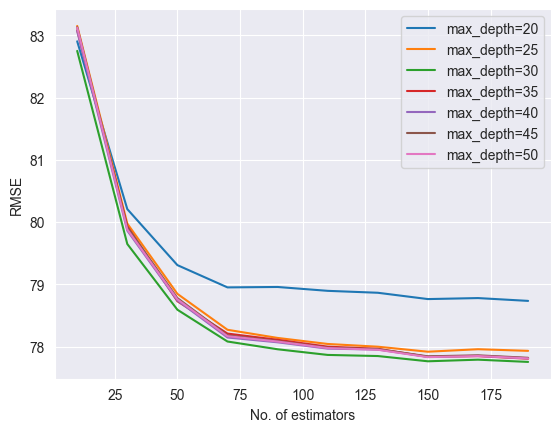

In [463]:
# plt.figure(figsize=(8, 6))
plt.xlabel('No. of estimators')
plt.ylabel('RMSE')
for d in tqdm([20, 25, 30, 35, 40, 45, 50]):
    plt.plot(df_scores[df_scores.max_depth == d].n_estimators,
             df_scores[df_scores.max_depth == d].rmse,
             label=f'max_depth={d}')
plt.legend()

### Tune `min_samples_leaf`

In [464]:
# Based on the above graph, optimal max_depth is 30.
max_depth = 30

# Finding the optimal min_samples_leaf
scores = []
for s in tqdm([1, 3, 5, 10, 50]):
    for n in tqdm(range(10, 201, 20)):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=max_depth,
                                   min_samples_leaf=s,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        scores.append((n, s, rmse, mae))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [465]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'min_samples_leaf', 'rmse', 'mae'])
df_scores

,n_estimators,min_samples_leaf,rmse,mae
0,10,1,82.749170,56.151398
1,30,1,79.647569,54.457571
2,50,1,78.591844,53.994418
3,70,1,78.081145,53.686325
4,90,1,77.956769,53.682695
5,110,1,77.865872,53.710752
6,130,1,77.847921,53.699541
7,150,1,77.763661,53.670636
8,170,1,77.789606,53.669684
9,190,1,77.753469,53.663693


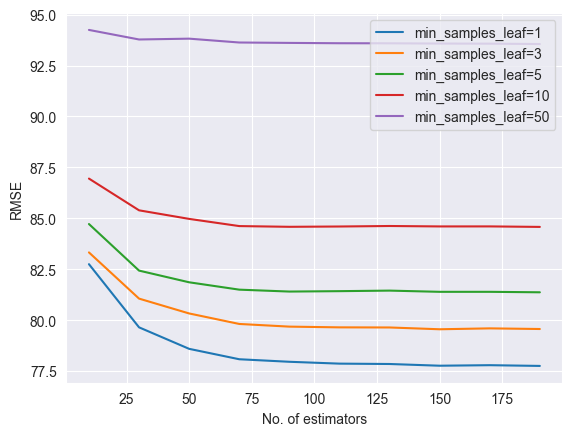

In [466]:
# plt.figure(figsize=(10, 8))
plt.xlabel('No. of estimators')
plt.ylabel('RMSE')
for s in [1, 3, 5, 10, 50]:
    plt.plot(df_scores[df_scores.min_samples_leaf == s].n_estimators,
             df_scores[df_scores.min_samples_leaf == s].rmse,
             label=f'min_samples_leaf={s}')
plt.legend()

### Benchmark 2
Training the model using the optimal parameter values from the above assessment.

In [467]:
n_estimators = 150
max_depth = 30
min_samples_leaf = 1

rf = RandomForestRegressor(n_estimators=n_estimators,
                           max_depth=max_depth,
                           min_samples_leaf=min_samples_leaf,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)

rf_performance = [('rmse', rmse),
                  ('mae', mae)]
pd.DataFrame(rf_performance, columns=['metric', 'score'])

,metric,score
0,rmse,77.763661
1,mae,53.670636


**Result:**
Benchmark 2 results is slightly better than Benchmark 1. Therefore, Benchmark 2 will be used as the benchmark for the model performance and will be used for comparison when measuring performance of the gradient boosting models in the next section.

# XGBoost

### Tune `eta`

In [32]:
features = dv.get_feature_names_out()
dm_train = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dm_val = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dm_test = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [560]:
def train_gb_model(dm_train,
                   eta=0.3,
                   max_depth=6,
                   min_child_weight=1,
                   num_boost_round=201,
                   watchlist=[(dm_train, 'train'), (dm_val, 'val')]):
    xgb_params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,

        'eval_metric': 'rmse',
        'objective': 'reg:squarederror',
        'nthread': -1,

        'seed': 1,
        'verbosity': 1
    }
    evals_result = {}
    model = xgb.train(params=xgb_params,
                      dtrain=dm_train,
                      num_boost_round=num_boost_round,
                      evals=watchlist,
                      evals_result=evals_result,
                      verbose_eval=False)

    columns = ['eta', 'iter', 'train_rmse', 'val_rmse']
    train_rmse_scores = list(evals_result['train'].values())[0]
    val_rmse_scores = list(evals_result['val'].values())[0]

    df_scores = pd.DataFrame(
        list(zip([eta] * len(train_rmse_scores),
                 range(1, len(train_rmse_scores) + 1),
                 train_rmse_scores,
                 val_rmse_scores
                 )), columns=columns)
    return model, df_scores

In [180]:
scores = pd.DataFrame()
for eta in tqdm([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 1.0]):
    key = f'eta={eta}'
    _, df_scores = train_gb_model(dm_train,
                                  eta=eta,
                                  num_boost_round=201)
    scores = pd.concat([scores, df_scores])

  0%|          | 0/7 [00:00<?, ?it/s]

[0]	train-rmse:1186.86540	val-rmse:1184.63769
[1]	train-rmse:1175.09764	val-rmse:1172.90868
[2]	train-rmse:1163.44857	val-rmse:1161.29979
[3]	train-rmse:1151.91663	val-rmse:1149.80553
[4]	train-rmse:1140.50056	val-rmse:1138.42957
[5]	train-rmse:1129.19977	val-rmse:1127.16649
[6]	train-rmse:1118.01302	val-rmse:1116.01953
[7]	train-rmse:1106.93883	val-rmse:1104.98255
[8]	train-rmse:1095.97645	val-rmse:1094.05917
[9]	train-rmse:1085.12432	val-rmse:1083.24315
[10]	train-rmse:1074.38178	val-rmse:1072.53740
[11]	train-rmse:1063.74735	val-rmse:1061.93813
[12]	train-rmse:1053.22041	val-rmse:1051.44859
[13]	train-rmse:1042.79940	val-rmse:1041.06289
[14]	train-rmse:1032.48325	val-rmse:1030.78196
[15]	train-rmse:1022.27142	val-rmse:1020.60423
[16]	train-rmse:1012.16287	val-rmse:1010.53021
[17]	train-rmse:1002.15608	val-rmse:1000.55751
[18]	train-rmse:992.25001	val-rmse:990.68501
[19]	train-rmse:982.44418	val-rmse:980.91323
[20]	train-rmse:972.74054	val-rmse:971.24570
[21]	train-rmse:963.13388	val

In [184]:
scores.sort_values(by='val_rmse', ascending=True).reset_index().iloc[::200]

,index,eta,iter,train_rmse,val_rmse
0,199,0.30,200,43.937635,76.946020
200,125,0.40,126,48.167300,78.603832
400,57,0.40,58,63.281270,81.153166
600,91,0.10,92,76.461372,84.894424
800,48,0.10,49,83.133944,89.090067
1000,149,1.00,150,33.623965,95.135644
1200,151,0.01,152,277.219920,278.450527
1400,5,0.01,6,1129.199768,1127.166493


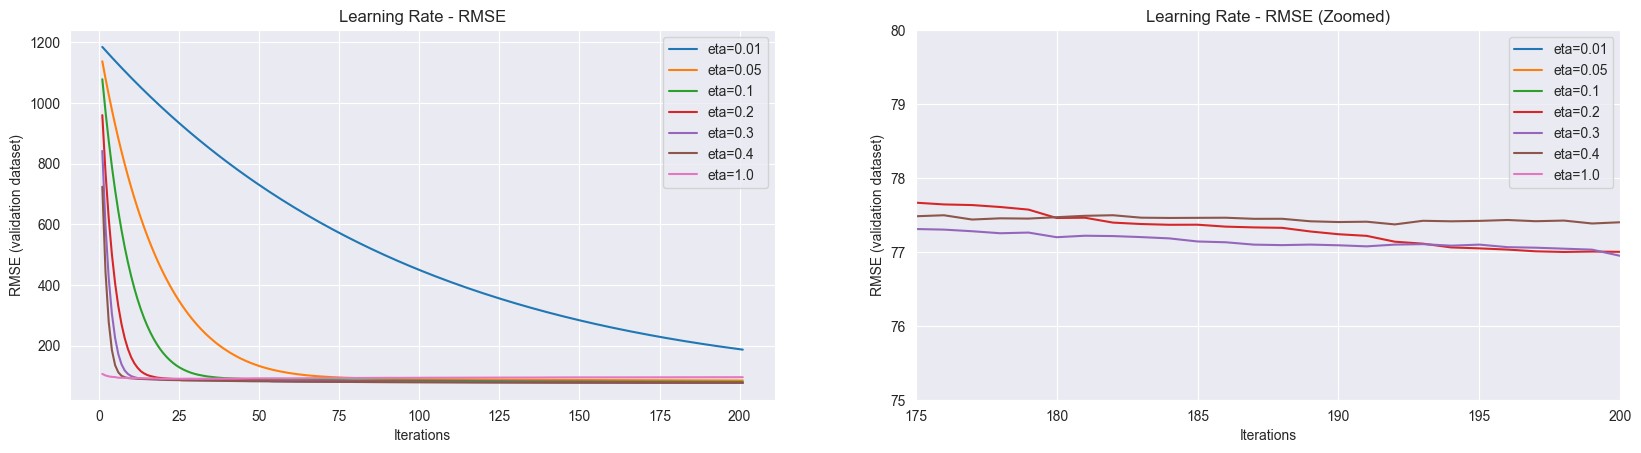

In [218]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(20)

axs[0].set_title('Learning Rate - RMSE')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('RMSE (validation dataset)')
gs = scores.groupby('eta')
gs.get_group(1.00)
gs.groups.values()
for eta in gs.groups.keys():
    df = gs.get_group(eta)
    axs[0].plot(df.iter, df.val_rmse, label=f'eta={eta}')
    axs[0].legend()

axs[1].set_title('Learning Rate - RMSE (Zoomed)')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('RMSE (validation dataset)')
axs[1].set_xlim([175, 200])
axs[1].set_ylim([75, 80])
gs = scores.groupby('eta')
gs.get_group(1.00)
gs.groups.values()
for eta in gs.groups.keys():
    df = gs.get_group(eta)
    axs[1].plot(df.iter, df.val_rmse, label=f'eta={eta}')
    axs[1].legend()

In [221]:
# Base on the above analysis, eta=0.3 gives the best performance as the learning rate.
chosen_eta = 0.3

### Tune `max_depth`

In [227]:
scores = {}
for max_depth in [3, 4, 6, 10, 14, 18]:
    key = f'max_depth={max_depth}'
    _, scores[key] = train_gb_model(dm_train,
                                    eta=chosen_eta,
                                    max_depth=max_depth,
                                    num_boost_round=201)

[0]	train-rmse:843.31052	val-rmse:842.21830
[1]	train-rmse:595.95829	val-rmse:595.81634
[2]	train-rmse:424.50088	val-rmse:425.14712
[3]	train-rmse:307.21073	val-rmse:308.42422
[4]	train-rmse:228.05088	val-rmse:229.74065
[5]	train-rmse:176.40436	val-rmse:178.33551
[6]	train-rmse:143.95507	val-rmse:146.01887
[7]	train-rmse:124.61133	val-rmse:126.72099
[8]	train-rmse:113.51568	val-rmse:115.70801
[9]	train-rmse:107.47187	val-rmse:109.55232
[10]	train-rmse:103.80215	val-rmse:105.91753
[11]	train-rmse:101.82885	val-rmse:103.85124
[12]	train-rmse:99.25935	val-rmse:101.21578
[13]	train-rmse:98.51158	val-rmse:100.47640
[14]	train-rmse:97.89974	val-rmse:99.96538
[15]	train-rmse:97.56452	val-rmse:99.64022
[16]	train-rmse:97.13048	val-rmse:99.16059
[17]	train-rmse:96.65423	val-rmse:98.67907
[18]	train-rmse:96.35448	val-rmse:98.43157
[19]	train-rmse:95.96636	val-rmse:98.07175
[20]	train-rmse:95.69134	val-rmse:97.84970
[21]	train-rmse:95.45257	val-rmse:97.63852
[22]	train-rmse:95.17392	val-rmse:97.3

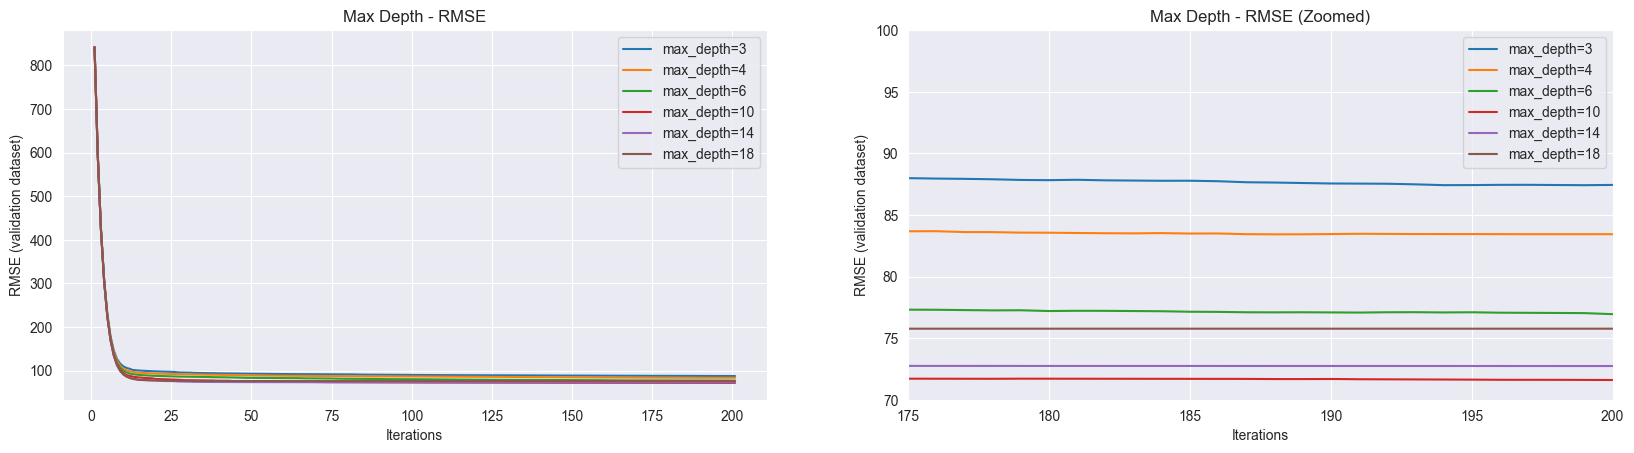

In [229]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(20)

axs[0].set_title('Max Depth - RMSE')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('RMSE (validation dataset)')
for key, df_scores in scores.items():
    axs[0].plot(df_scores.iter, df_scores.val_rmse, label=key)
    axs[0].legend()

axs[1].set_title('Max Depth - RMSE (Zoomed)')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('RMSE (validation dataset)')
axs[1].set_xlim([175, 200])
axs[1].set_ylim([70, 100])
for key, df_scores in scores.items():
    axs[1].plot(df_scores.iter, df_scores.val_rmse, label=key)
    axs[1].legend()

In [231]:
# The above analysis shows max_depth=10 gies the best performance.
chosen_max_depth = 10

### Tune `min_child_weight`

In [563]:
scores = {}
for min_child_weight in [1, 10, 30, 40]:
    key = f'min_child_weight={min_child_weight}'
    _, scores[key] = train_gb_model(dm_train,
                                    eta=chosen_eta,
                                    max_depth=chosen_max_depth,
                                    min_child_weight=min_child_weight,
                                    num_boost_round=201)

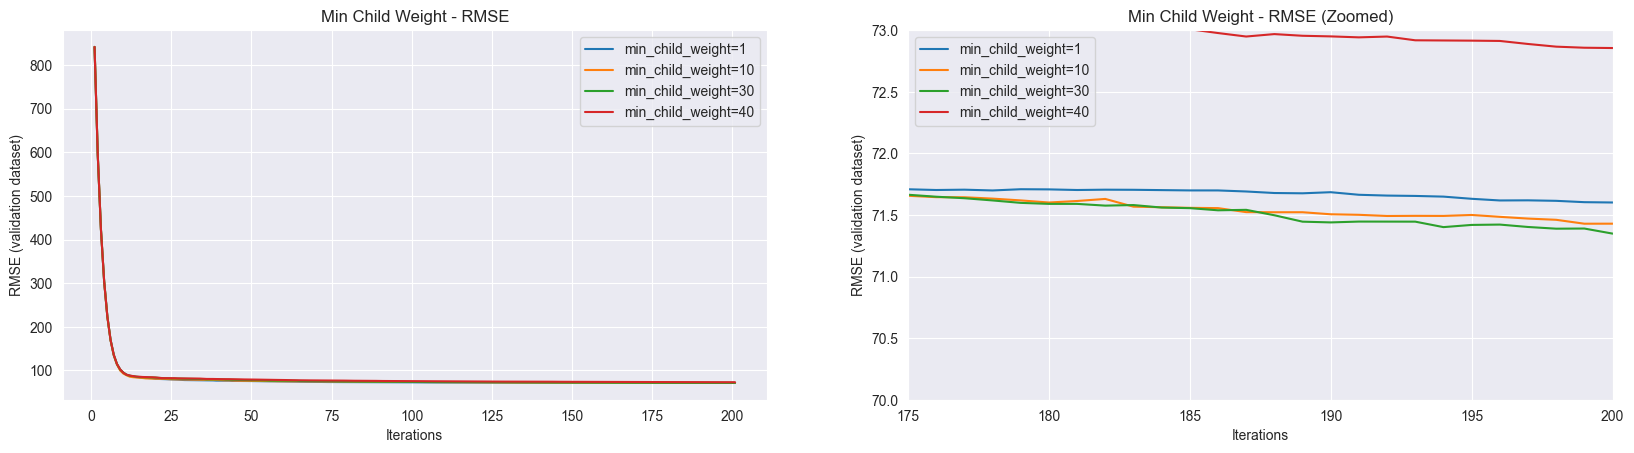

In [566]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(20)

axs[0].set_title('Min Child Weight - RMSE')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('RMSE (validation dataset)')
for min_child_weight, df in scores.items():
    df = scores[min_child_weight]
    axs[0].plot(df.iter, df.val_rmse, label=min_child_weight)
    axs[0].legend()

axs[1].set_title('Min Child Weight - RMSE (Zoomed)')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('RMSE (validation dataset)')
axs[1].set_xlim([175, 200])
axs[1].set_ylim([70, 73])
for min_child_weight, df in scores.items():
    df = scores[min_child_weight]
    axs[1].plot(df.iter, df.val_rmse, label=min_child_weight)
    axs[1].legend()

In [567]:
# The above analysis shows min_child_weight=30 gives the best performance.
chosen_min_child_weight = 30

### Final GB model

rmse of xgb model on test set = 71.34839727378294


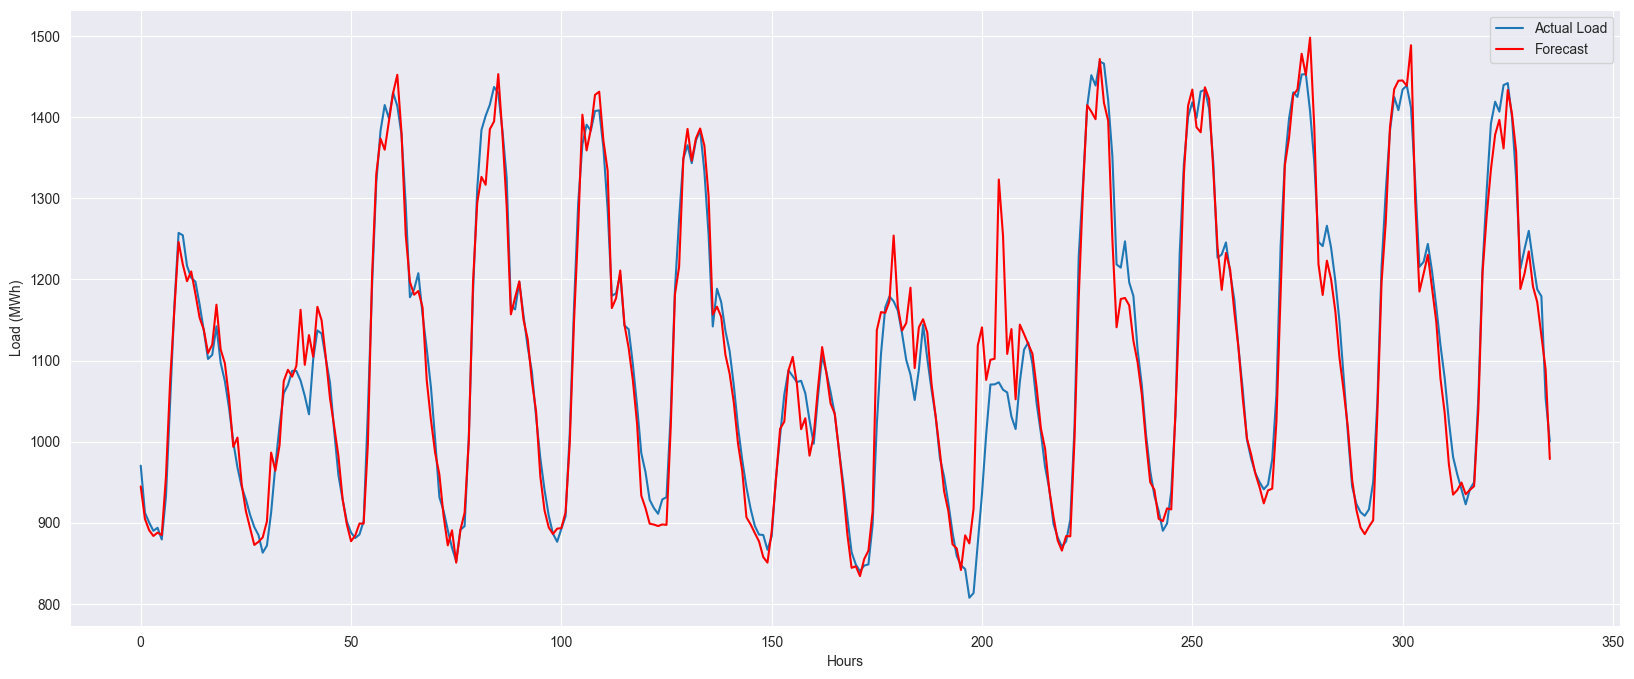

In [568]:
# Training the model with train set and the chosen values for the parameters

num_boost_round = 200

(model, scores) = train_gb_model(dm_train = dm_train,
                                 eta=chosen_eta,
                                 max_depth=chosen_max_depth,
                                 min_child_weight=chosen_min_child_weight,
                                 num_boost_round=201)
gb_rmse = scores.sort_values(by='val_rmse').iloc[0, 3]
print(f'rmse of xgb model on test set = {gb_rmse}')

full_dicts = df_full.to_dict(orient='records')
X_full = dv.transform(full_dicts)
dm_full = xgb.DMatrix(X_full, label=y_full, feature_names=features)

y_full_pred = model.predict(dm_full)

plt.figure(figsize=(20, 8))
load_period = 24 * 14
actual = y_full[:load_period]
predict = y_full_pred[:load_period]
plt.plot(actual.index, list(actual), label='Actual Load')
plt.plot(actual.index, list(predict), color='red', label='Forecast')
plt.xlabel('Hours')
plt.ylabel('Load (MWh)')
plt.legend()

rmse of xgb model on full_train set = 65.31907551143627


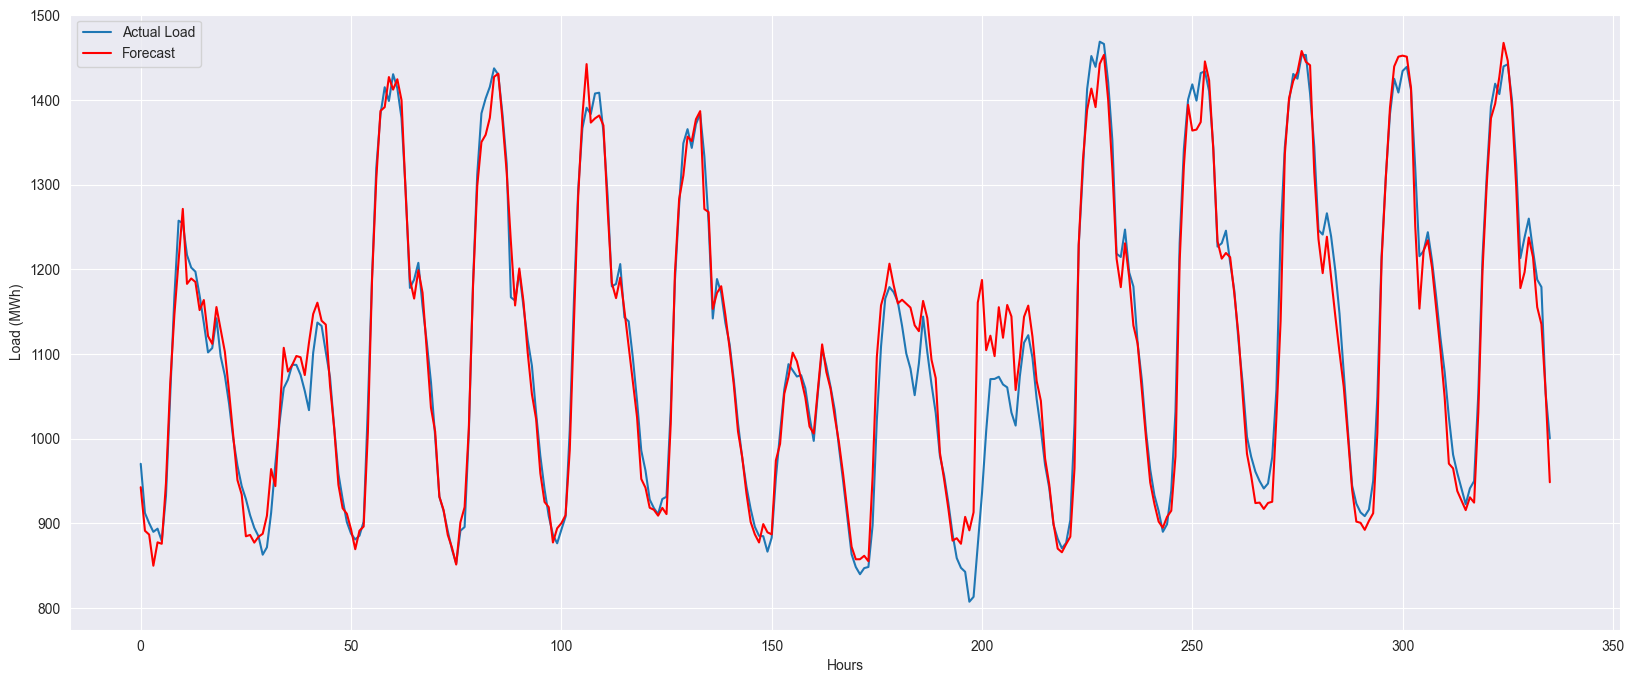

In [569]:
# training with full_train and chosen params, and measure the performance
full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(full_train_dicts)
dm_full_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
(model, scores) = train_gb_model(dm_train=dm_full_train,
                                 eta=chosen_eta,
                                 max_depth=chosen_max_depth,
                                 min_child_weight=chosen_min_child_weight,
                                 num_boost_round=201,
                                 watchlist=[(dm_full_train, 'train'), (dm_test, 'val')])
gb_rmse = scores.sort_values(by='val_rmse').iloc[0, 3]
print(f'rmse of xgb model on full_train set = {gb_rmse}')

# We get much better RMSE compared to what we got from train set. Let's plot the full timeseries with predictions from the new model.
y_full_pred = model.predict(dm_full)

plt.figure(figsize=(20, 8))
load_period = 24 * 14
actual = y_full[:load_period]
predict = y_full_pred[:load_period]
plt.plot(actual.index, list(actual), label='Actual Load')
plt.plot(actual.index, list(predict), color='red', label='Forecast')
plt.xlabel('Hours')
plt.ylabel('Load (MWh)')
plt.legend()